In [1]:
from time import time
import datetime
from scipy.stats import spearmanr, stats
from scipy.spatial.distance import euclidean
from random import randint, shuffle,sample,random
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
path='/Users/fesponda/research/Diversity/Data/transforms_to_compare'
indexes=['PDM','Euclidean','Hamming']

In [2]:
def read_ELF_file(file1,file2):
    with open(file1, 'rb') as f:
        P1=list(f.read())
    with open(file2, 'rb') as f:
        P2=list(f.read())
    return P1,P2


#P2=P1

In [3]:
def read_ELF(file1):
    with open(file1, 'rb') as f:
        P1=list(f.read())
    return P1



In [4]:
def readfile(name):
    P1=[]
    P2=[]
    with open(name) as fp:
        lines=fp.readlines()
    for line in lines:
        l=line.strip().split(',')
        P1.append(int(l[0]))
        P2.append(int(l[1]))
    return P1,P2

In [5]:
def read_pov_results(path,transform,result_file='results.txt'):
    #with open('/Users/fesponda/research/Diversity/Data/transforms_to_compare/structNoc/results.txt') as fp:
    result={}
    with open(path+'/'+transform+'/'+result_file) as fp:
        lines=fp.readlines()
    for line in lines:
        if line.find('Still vulnerable')>=0:
            total=int(line.split()[5])
            num=float(line.split()[3])
            result['Still vulnerable']=(total-num)/total
        if line.find('Showed Divergence')>=0:
            total=int(line.split()[5])
            num=float(line.split()[3])
            result['Showed Divergence']=num/total
    return (result)

          

In [6]:
# We will need to pad, for now with zeroes or 64's
def pad(P1,P2, value=0,extend=True):
    if extend:
        B1=[i for i in P1 ]
        B2=[i for i in P2 ]
        if (len(P1)> len(P2)):
            B2+=[value for i in range(len(P1)-len(P2)) ]
        else:
            B1+=[value for i in range(len(P2)-len(P1)) ]
    else:
        if (len(P1)< len(P2)):
            B1=[i for i in P1 ]
            B2=[P2[i] for i in range(len(P1)) ]
        else:
            B2=[i for i in P2 ]
            B1=[P1[i] for i in range(len(P2)) ]      
            
    return B1,B2


In [7]:
def hamm_sim(P1,P2):
    if len(P1) != len(P2):
        print('Length mismatch')
        return -1
    matches=0
    for i in range(len(P1)):
        if P1[i]==P2[i]:
            matches+=1
    return matches/len(P1)

In [8]:
def euclidean_sim(B1,B2,min_val=0,max_val=255):#to normalize with max distance for bytecodes
    return 1.0-(euclidean(B1,B2)/np.sqrt(len(B1)*((max_val-min_val)**2)))

In [9]:
##Create dictionary. For each byte in the block we create unique entry. If a byte is repeated we append if its the first, second, etc occurrence
def P1_dictionary(P1):
    P1_dict={}
    P1_occ={}
    for index,byte in enumerate(P1):   
        if byte  in P1_occ.keys():
            P1_occ[byte]+=1
        else:
            P1_occ[byte]=1
        value=str(byte)+'_'+str(P1_occ[byte]) ## here we create a unique value for each byte in the section
        P1_dict[value]=index+1 #we start to count at 1
    return P1_dict

In [10]:
####Rank instructions of a block according to first file template
def rank_P2(P1_dict,P2,intersection=False):
    a=[]        
    b=[]
    med_rank=len(P1_dict.keys())/2.0
    P2_dict={}
    P2_occ={}
    for index,byte in enumerate(P2):   
        if byte  in P2_occ.keys():
            P2_occ[byte]+=1
        else:
            P2_occ[byte]=1
        value=str(byte)+'_'+str(P2_occ[byte]) ## here we create a unique value for each byte in the section
        if value in P1_dict.keys():
            P2_dict[value]=P1_dict[value]
            a.append(index+1)
            b.append(P2_dict[value])
        elif not intersection:
            P2_dict[value]=0 ###zero for no existent value....check Maybe not bother, Maybe random, maybe average
            P2_dict[value]=med_rank 
            #P2_dict[value]=randint(1,90)
            a.append(index+1)
            b.append(P2_dict[value])
            
    #print(len(a),len(b))
    return a,b



In [11]:
#l=['orig','probBilr1','probBilr2','probBilr3','structNoc1','structNoc2','structNoc3','full1','full2','full3']
#l=['full1','full2','full3']#,]
#l=['orig','structP1Can_1','structP1Can_2','structP1Can_3']
#l=['probBilr1','probBilr2','probBilr3']
#l=['structNoc1','structNoc2','structNoc3']

def compute_avg_distance(path,transform,intersect=True,metrics=['PDM']):
    #####Between variants
    l=['/'+transform+'/httpd-kudu-canonical_1','/'+transform+'/httpd-kudu-canonical_2','/'+transform+'/httpd-kudu-canonical_3']
    var_var_avg=[]
    in_between_variation={}
    variation_to_orig={}
    
    for index in metrics:
        in_between_variation[index]=[]
        variation_to_orig[index]=[]
    for i in range(len(l)):
        P1=read_ELF(path+l[i])
        P1_dict=P1_dictionary(P1)
        for j in range(len(l)):
            if i<j:
                P2=read_ELF(path+l[j])
                for index in metrics:
                    if index=='PDM':
                        a,b=rank_P2(P1_dict,P2,intersection=intersect)
                        corr,p=spearmanr(a,b)
                    if index=='Euclidean':
                        B1,B2=pad(P1,P2,value=0)
                        corr=euclidean_sim(B1,B2)
                    if index=='Hamming':
                        B1,B2=pad(P1,P2,value=0)
                        corr=hamm_sim(B1,B2)
                    in_between_variation[index].append((transform,corr))
                    


    ##variants to original
    var_orig_avg=[]
    P1=read_ELF(path+'/httpd-kudu-canonical_original')
    P1_dict=P1_dictionary(P1) #estaba mal
    for variant in l:
        P2=read_ELF(path+variant)
        for index in metrics:
            if index=='PDM':
                a,b=rank_P2(P1_dict,P2,intersection=intersect)
                corr,p=spearmanr(a,b)
            if index=='Euclidean':
                B1,B2=pad(P1,P2,value=0)
                corr=euclidean_sim(B1,B2)
            if index=='Hamming':
                B1,B2=pad(P1,P2,value=0)
                corr=hamm_sim(B1,B2)
            variation_to_orig[index].append((transform,corr))

        
        
        #var_orig_avg.append(corr)
        #print('spearman',l[i],l[j],spearmanr(a,b))
        #print('kendall',l[i],l[j],stats.kendalltau(a,b))
    #print(var_orig_avg)
    return(variation_to_orig,in_between_variation)


In [12]:
###Test
variation_to_orig,in_between_variation=compute_avg_distance(path,'probNog_probBilr',metrics=['PDM','Euclidean','Hamming'])
avg_to_orig={}
avg_to_others={}
for index in variation_to_orig.keys():
        avg_to_orig[index]={'probNog_probBilr':np.mean([value for trans,value in variation_to_orig[index]])}
        avg_to_others[index]={'probNog_probBilr':np.mean([value for trans,value in in_between_variation[index]])}
print(avg_to_orig,variation_to_orig)

{'PDM': {'probNog_probBilr': 0.9974584110208724}, 'Euclidean': {'probNog_probBilr': 0.5730876319505375}, 'Hamming': {'probNog_probBilr': 0.16470101375206248}} {'PDM': [('probNog_probBilr', 0.995871914266327), ('probNog_probBilr', 0.9965033187962907), ('probNog_probBilr', 0.9999999999999998)], 'Euclidean': [('probNog_probBilr', 0.572935628106134), ('probNog_probBilr', 0.5724598392143687), ('probNog_probBilr', 0.5738674285311098)], 'Hamming': [('probNog_probBilr', 0.16241949063919472), ('probNog_probBilr', 0.16237122524387432), ('probNog_probBilr', 0.16931232537311833)]}


In [ ]:
transforms=[
'2probBilr_probP1_probNos_probNol_probNoh_zipr+1structNoc_structP1Canaries_structNos_structNol_structNoh_zipr',
'2structNogOF_phase1_zipr+1probNog_phase1_zipr',
'2structNogOF_structSS_phase1_zipr+1probNog_probSS_phase1_zipr',
'probBilr',
'structNoc',
'structNoc_structP1Canaries',
'structP1Canaries',
'probNog_probBilr']
avg_to_orig={}
avg_to_others={}
for transform in transforms:
    variation_to_orig,in_between_variation=compute_avg_distance(path,transform,metrics=indexes)
    avg_to_orig[transform]={}
    avg_to_others[transform]={}
    for index in variation_to_orig.keys():
        avg_to_orig[transform][index]=np.mean([value for trans,value in variation_to_orig[index]])
        avg_to_others[transform][index]=np.mean([value for trans,value in in_between_variation[index]])


In [ ]:
###Read POV results
pov_results={}
for transform in transforms:
    pov_results[transform]=read_pov_results('/Users/fesponda/research/Diversity/Data/transforms_to_compare',transform)

In [ ]:
#pov_results

# Plots

In [ ]:
#avg_to_orig

In [ ]:
###
#success_criterion='Still vulnerable' contains the count of all but the still vulnerable
#success_criterion='Showed Divergence'
###
def plot_results(transforms,averages,pov_results,success_criterion='Still vulnerable',index='PDM',type_avg='',to_file=False ):
 ##we use this line in the file but the value we calculate are all but the still vulnerable
    plt.clf()
    x=[]
    y=[]
    
    for trans in transforms:
        x.append(averages[trans][index])
        y.append(pov_results[trans][success_criterion])

    plt.ylabel(success_criterion)
    plt.xlabel(index)
    plt.title("Diversity Index vs Effectivenes against POV \n " + type_avg)
    #plt.ylim([0.75, 1])
    plt.scatter(x,y,marker='.')
    if to_file:
        plt.savefig(path+'/figures/'+type_avg+success_criterion+index+datetime.datetime.fromtimestamp(time()).strftime('%Y-%m-%d %H:%M:%S')+'.pdf')

In [ ]:
average=avg_to_orig 
for index in indexes:
    plot_results(transforms,average,pov_results,index=index,type_avg='Average to Original',to_file=True)
average=avg_to_others 
for index in indexes:
    plot_results(transforms,average,pov_results,index=index,type_avg='Average Between Variants',to_file=True)

In [ ]:
###which average to use, to original avg_to_orig or to  others avg_to_others
average=avg_to_orig 

In [ ]:
plot_results(transforms,average,pov_results,index='PDM')

In [ ]:
plot_results(transforms,average,pov_results,index='Euclidean')

In [ ]:
plot_results(transforms,average,pov_results,index='Hamming')

In [31]:
plt.scatter(a[16000:16500],b[16000:16500],marker='.')

NameError: name 'a' is not defined

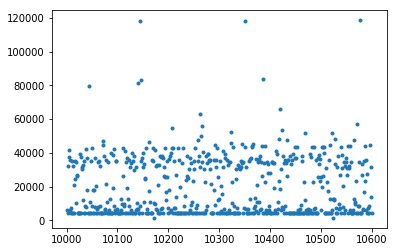

In [193]:
#random 
x1=a[10000:10600]
x2=b[10000:10600]
plt.scatter(x1,x2,marker='.')

# Known Problems
- If program that its a subset of another will have high similarity
- Does not obey triangle inequality
- If we dont dont only look at the interesection we loose symetry


In [330]:
def insertion(P1,intensity):
    P2=[]
    for i in range(len(P1)):
        P2.append(P1[i])
        if random()<intensity:
            P2.append(randint(0,255))
    return(P2)

In [326]:
def within_block_invert(size, intensity,step=100):
    #bloques
    indexes=list(range(size))
    for i in range(0,size,step):
        if random()< intensity:
            indexes[i:i+step]=reversed(indexes[i:i+step])
    return (indexes)

In [113]:
def within_block_randomize(size, intensity,step=100):
    #bloques
    indexes=list(range(size))
    for i in range(0,size,step):
        if random()< intensity:
            indexes[i:i+step]=sample(indexes[i:i+step],len(indexes[i:i+step]))
    return (indexes)

In [210]:
def block_randomize(P2,step=100):
    #move block or not. If not it stays in place if yes it implies 2 blocks move...
    # easier if move just swap (could happen twice). First just shuffle blocks
    indexes=list(range(0,len(P2),step))
    shuffle(indexes)
    P3=[]
    for i in indexes:
        P3+=P2[i:i+step]
    return(P3)
        

In [212]:
indexes=list(range(0,10,3))
print(indexes)
shuffle(indexes)
print(indexes)
l=list(range(10))
block_randomize(l,3)

[0, 3, 6, 9]
[9, 0, 3, 6]


[9, 3, 4, 5, 6, 7, 8, 0, 1, 2]

In [112]:
print(within_block_randomize(10,0.5,4))

si 0 4
si 8 12
[1, 0, 3, 2, 4, 5, 6, 7, 9, 8]


In [233]:
#P1,P2=readfile('fake_data.csv')
P1,P2=read_ELF_file('/Users/fernando/Downloads/executables_to_compare/Prueba2/orig',\
              '/Users/fernando/Downloads/executables_to_compare/Prueba2/full3')

P1_dict=P1_dictionary(P1)


In [258]:
len(P1)

751996

In [284]:
ind2=within_block_randomize(len(P1),0.9,1000)
P2=list(np.asarray(P1)[ind2])
P2=block_randomize(P2,100000)
a,b=rank_P2(P1_dict,P2,intersection=True)
print(spearmanr(a,b))
#print(stats.weightedtau(a,b))
print(stats.kendalltau(a,b))

SpearmanrResult(correlation=0.6688635535551883, pvalue=0.0)
KendalltauResult(correlation=0.5238259845938973, pvalue=0.0)


In [331]:
P1_dict=P1_dictionary(P1)
avg={}
for j in [1000,10000,100000]:#[0.5,0.7,0.9]:
    avg[j]=0
    for i in range(10):
        ind2=within_block_invert(len(P1),0.5,1000)
        P2=list(np.asarray(P1)[ind2])
        P2=block_randomize(P2,j)
        #P2=insertion(P1,0.5)
        a,b=rank_P2(P1_dict,P2,intersection=True)     
        c,p=spearmanr(a,b)
        #c,p=stats.kendalltau(a,b)
        #c=euclidean(P1,P2)
        print(c)
        avg[j]+=c
    avg[j]/=(i+1)
#print(stats.kendalltau(a,b))
print('promedio',avg)

0.845804380278565
0.8457218216250689
0.8455658179943896
0.8451044574952741
0.8460686630248765
0.8449804984259237
0.8454170884782805
0.8456803932600466
0.8453774790495148
0.8455573641870573
0.8452017126466943
0.8461436013658488
0.8459060780591051
0.8453151477328761
0.8454421985399031
0.8452643077913593
0.8451461723316578
0.8450829281109702
0.8458632538490418
0.8452653300361198
0.8458061754000846
0.8451868290622657
0.8455605757445424
0.8453035350784172
0.8449441722104752
0.8453078548505829
0.8454839168889959
0.8453469105022957
0.8460646771130498
0.8462533512438357
promedio {1000: 0.8455277963818997, 10000: 0.8454630730463577, 100000: 0.8455257998094545}


In [302]:
euclidean(a,b)

114746.30258966953

In [287]:
avg

{1000: 0.8215303258610446,
 10000: 0.7984494492300221,
 100000: 0.7542824895965139}

In [278]:
#ind2=within_block_randomize(len(P1),j,10)
c,p=spearmanr(a,b)
print (c)

0.8155251463015588


In [301]:
P1_dict=P1_dictionary(P1)
P2=list(np.asarray(P1)[ind2])
a,b=rank_P2(P1_dict,P2,intersection=False)

In [325]:
np.asarray(P1)[ind2]
l=[1,2,3,4,5,6,7]
print(l)
l[0:3]=reversed(l[0:3])
print(l)

[1, 2, 3, 4, 5, 6, 7]
[3, 2, 1, 4, 5, 6, 7]


In [183]:
list(zip(np.asarray(P1),np.asarray(P1)[ind2]))[0:30]

[(127, 0),
 (69, 1),
 (76, 70),
 (70, 76),
 (2, 69),
 (1, 1),
 (1, 127),
 (0, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 3),
 (0, 0),
 (0, 0),
 (3, 62),
 (0, 0),
 (62, 0),
 (0, 0),
 (1, 210),
 (0, 1),
 (0, 166),
 (0, 0),
 (210, 0),
 (166, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]

In [307]:
list(zip(a,b))[30000:30030]

[(182786, 97),
 (182787, 32819),
 (182788, 233324),
 (182789, 64662),
 (183393, 90920),
 (183394, 11785),
 (183395, 21937),
 (183396, 233823),
 (183397, 64678),
 (183585, 90923),
 (183586, 8801),
 (183587, 33331),
 (183588, 233829),
 (183589, 64753),
 (183665, 91557),
 (183666, 8305),
 (183667, 34629),
 (183668, 233880),
 (183669, 64774),
 (184177, 91787),
 (184178, 5290),
 (184179, 9369),
 (184180, 233974),
 (184181, 64790),
 (184369, 91856),
 (184370, 2673),
 (184371, 9553),
 (184372, 233991),
 (184373, 64806),
 (184385, 91978)]

In [132]:
len(P1)

751996

In [188]:
list(zip(P1,P2))[3000:3030]

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (209, 4),
 (4, 0),
 (0, 0),
 (0, 0),
 (18, 0),
 (0, 128),
 (0, 12),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 160),
 (0, 150),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 160)]

In [306]:
list(zip(P1,P2))

[(127, 127),
 (69, 69),
 (76, 76),
 (70, 70),
 (2, 2),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (3, 3),
 (0, 0),
 (62, 62),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (210, 210),
 (166, 166),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (64, 84),
 (0, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (64, 64),
 (131, 188),
 (10, 212),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (64, 64),
 (0, 0),
 (56, 56),
 (0, 0),
 (9, 184),
 (0, 0),
 (64, 64),
 (0, 0),
 (38, 250),
 (0, 1),
 (35, 249),
 (0, 1),
 (6, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (5, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (64, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (64, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (64, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (248, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (248, 0),
 (1